In [6]:
import tensorflow as tf


In [7]:
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [8]:
dataframe = tf.keras.utils.image_dataset_from_directory(
    'PlantVillage',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 20638 files belonging to 15 classes.


In [5]:
classnames = dataframe.class_names
print(classnames)
EPOCHS = 50

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [5]:
len(dataframe)

645

C:\Users\supri\AppData\Local\Temp\ipykernel_13904\1484563861.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5,4,i+1)


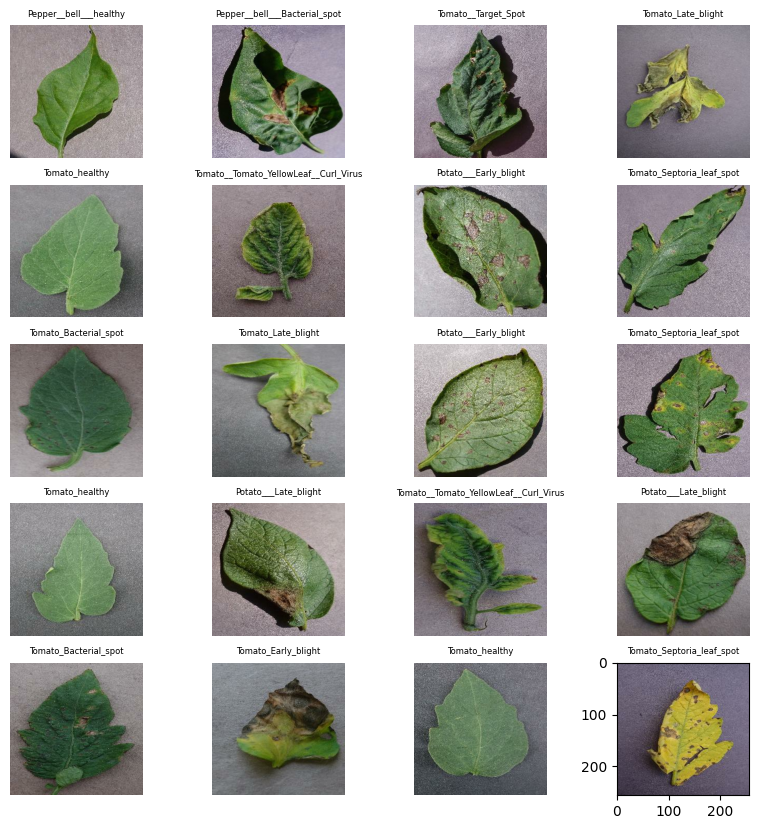

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataframe.take(1):
    for i in range(20):
        plt.axis("off")
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classnames[label_batch[i]],fontsize=6)

In [7]:
train_ds = dataframe.take(500).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = dataframe.skip(500).take(70).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = dataframe.skip(570).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# resize, rescale
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [10]:
IMAGE_SIZE=256
input_shape=(32,IMAGE_SIZE,IMAGE_SIZE,3)
classes=15
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(40,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(65,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(65,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(65,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(65,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(classes,activation='softmax'),
])

In [11]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 40)        1120      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 40)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 65)        23465     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 65)          0         
 g2D)                                                 

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
history=model.fit(train_ds,
    epochs=EPOCHS,
    batch_size=32,
    verbose=1,
    validation_data=validation_ds
)

Epoch 1/50
500/500 [==============================] - 552s 1s/step - loss: 1.9505 - accuracy: 0.3644 - val_loss: 1.7610 - val_accuracy: 0.4600
Epoch 2/50
500/500 [==============================] - 505s 1s/step - loss: 1.0008 - accuracy: 0.6675 - val_loss: 1.0639 - val_accuracy: 0.6580
Epoch 3/50
500/500 [==============================] - 512s 1s/step - loss: 0.7327 - accuracy: 0.7510 - val_loss: 1.1263 - val_accuracy: 0.6497
Epoch 4/50
500/500 [==============================] - 514s 1s/step - loss: 0.5836 - accuracy: 0.8018 - val_loss: 0.8961 - val_accuracy: 0.7289
Epoch 5/50
500/500 [==============================] - 500s 1000ms/step - loss: 0.5041 - accuracy: 0.8271 - val_loss: 0.6754 - val_accuracy: 0.7786
Epoch 6/50
500/500 [==============================] - 512s 1s/step - loss: 0.4236 - accuracy: 0.8554 - val_loss: 0.4885 - val_accuracy: 0.8470
Epoch 7/50
500/500 [==============================] - 504s 1s/step - loss: 0.3779 - accuracy: 0.8705 - val_loss: 0.5703 - val_accuracy: 0.

In [16]:
score=model.evaluate(test_ds)

70/70 [==============================] - 14s 204ms/step - loss: 0.2557 - accuracy: 0.9187


Actuacl label: Tomato_Bacterial_spot
1/1 [==============================] - 0s 229ms/step
Tomato_Bacterial_spot


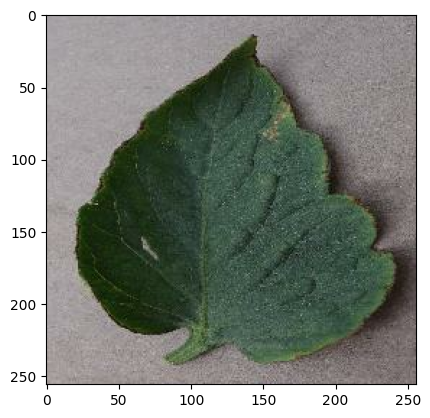

In [32]:
import numpy as np
for firstb_image,firstb_label in test_ds.take(1):
    plt.imshow(firstb_image[0].numpy().astype('uint8'))
    print("Actuacl label:",classnames[firstb_label[0].numpy()])
    batch_prediction = model.predict(firstb_image)
    print(classnames[np.argmax(batch_prediction[0])])

In [43]:
def predict(model,image):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    p=model.predict(img_array)
    predicted_class = classnames[np.argmax(p[0])]
    conf = round(100* (np.max(p[0])),2)
    return predicted_class, conf

1/1 [==============================] - 0s 31ms/step


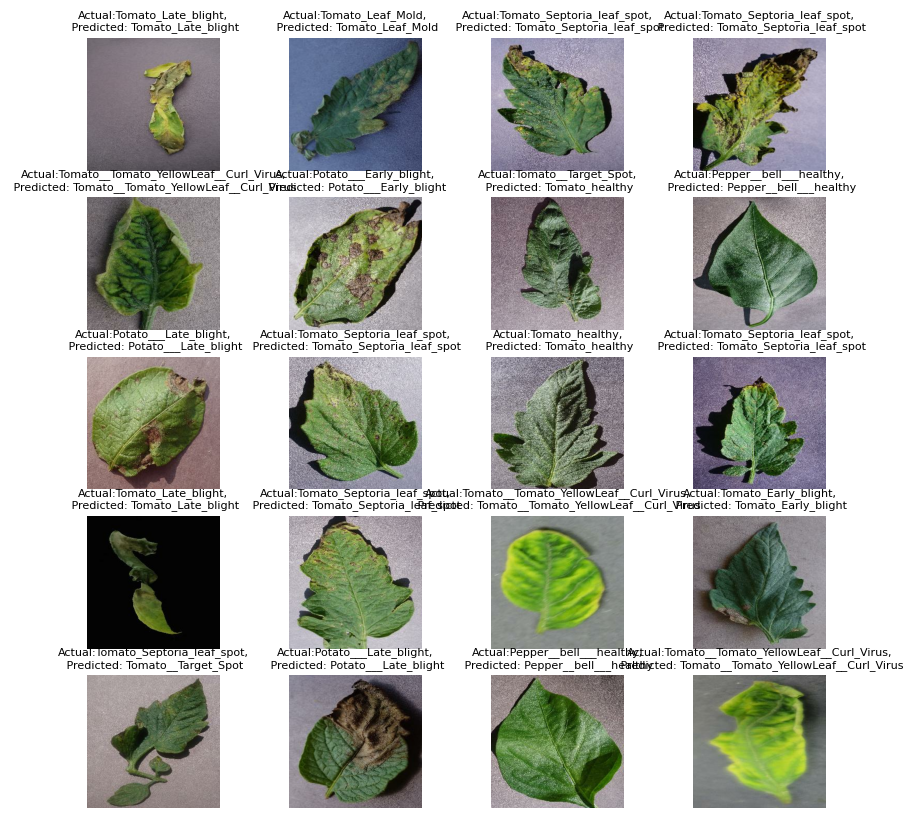

In [45]:
plt.figure(figsize=(10,10))
for images,labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        pc,conf = predict(model, images[i].numpy())
        plt.axis("off")
        plt.title(f"Actual:{classnames[labels[i]]},\n Predicted: {pc}",fontsize=8)

In [48]:
import os

model_version=len(os.listdir("./models"))+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/3\assets


INFO:tensorflow:Assets written to: ./models/3\assets


In [4]:
import tensorflow as tf
new=tf.keras.models.load_model("./models/1")
new.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 40)      1120      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 40)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 65)      23465     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 65)        0         
 g2D)                                                 

In [5]:
new.save('prod.h5')

C:\Users\supri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
